In [2]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

import os

# https://youtu.be/hraKTseOuJA

"""
Dataset from here: https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html
"""


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from PIL import Image
import requests
import shutil
import urllib


#Now let us read metadata to get our Y values (multiple lables)
os.chdir("/Users/jonas/Documents/art-classification/")
df = pd.read_csv('data/wikiart_scraped.csv')
print(df.head())     # printing first five rows of the file
print(df.columns)

styles = ["Barroque", "Neoclassism", "Romanticism", "Realism"]


df = df[df["Style"].isin(styles)]
print(df.iloc[:20])

print(df.shape)

print(df.loc[df["Style"]=="Neoclassism"])


#save images
image_directory = os.getcwd()+"/data/img"
os.chdir(image_directory)

""" Test for a single image
img_url = "https://uploads3.wikiart.org/00265/images/ancient-egyptian-painting/narmer-palette.jpg"
img = Image.open(requests.get(img_url, stream = True).raw)
img = img.resize((300,300))
img.save("bla.jpg")
"""
"""
for index, row in df.iterrows():
    img = Image.open(requests.get(row["Link"], stream=True).raw)
    img = img.resize((300, 300))
    img.convert("RGB").save(str(index) + ".jpg")
"""

            Style                                    Artwork         Artist  \
0  Early-Dynastic                             Narmer Palette  Ancient Egypt   
1  Early-Dynastic         Box Inlay with a Geometric Pattern  Ancient Egypt   
2     Old-Kingdom                           Khafre Enthroned  Ancient Egypt   
3  Middle-Kingdom  Stele of the Serpent King (Stela of Djet)  Ancient Egypt   
4  Middle-Kingdom  Laden Donkeys and Ploughing, Tomb of Djar  Ancient Egypt   

           Date                                               Link  
0       3050 BC  https://uploads3.wikiart.org/00265/images/anci...  
1  3100-2900 BC  https://uploads2.wikiart.org/00244/images/anci...  
2       2570 BC  https://uploads2.wikiart.org/00305/images/anci...  
3       3000 BC  https://uploads7.wikiart.org/00305/images/anci...  
4  2060-2010 BC  https://uploads8.wikiart.org/00244/images/anci...  
Index(['Style', 'Artwork', 'Artist', 'Date', 'Link'], dtype='object')
             Style                       

'\nfor index, row in df.iterrows():\n    img = Image.open(requests.get(row["Link"], stream=True).raw)\n    img = img.resize((300, 300))\n    img.convert("RGB").save(str(index) + ".jpg")\n'

In [3]:
#df = df.iloc[:2000]  #Loading only first 1000 datapoints for memory reasons
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to
#the metadata from the csv file.

SIZE = 200
X_dataset = []
#for i in tqdm(range(df.shape[0])):
for index, row in df.iterrows():
    img = image.image_utils.load_img(image_directory + "/" + str(index) + '.jpg', target_size=(SIZE,SIZE,3))
    img = image.image_utils.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

X = np.array(X_dataset)

#
print(df.iloc[50])  #Artwork    Hanibal victorious contemplates Italy from the...

print(df.iloc[50]["Style"])  #Tagged as Romanticism

#Id and Genre are not labels to be trained. So drop them from the dataframe.
#No need to convert to categorical as the dataset is already in the right format.

for style in styles:
    df[style] = 0 #1 if (df["Style"]==style) else 0
    df.loc[df["Style"]==style, style] = 1

y = np.array(df.drop(['Style', 'Artwork', 'Artist', 'Date', 'Link'], axis=1))

print(len(X))
print(len(y))


Style                                            Romanticism
Artwork    Hanibal victorious contemplates Italy from the...
Artist                                        Francisco Goya
Date                                                    1771
Link       https://uploads7.wikiart.org/images/francisco-...
Name: 26644, dtype: object
Romanticism
7200
7200


In [17]:
import tensorflow as tf

newModel = False
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

if newModel:
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(SIZE,SIZE,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(styles), activation='sigmoid')) # changed from 25 to 1 so I get no error

    #Do not use softmax for multilabel classification
    #Softmax is useful for mutually exclusive classes, either cat or dog but not both.
    #Also, softmax outputs all add to 1. So good for multi class problems where each
    #class is given a probability and all add to 1. Highest one wins.

    #Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
    #like multi label, in this example.
    #But, also good for binary mutually exclusive (cat or not cat).

    model.summary()

    #Binary cross entropy of each label. So no really a binary classification problem but
    #Calculating binary cross entropy for each label.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

    # save model
    !mkdir -p saved_model
    model.save('saved_model/my_model')

else:
    model = keras.models.load_model('saved_model/my_model')
    #history = model.evaluate(X_test, y_test, verbose=2)
    #history.history=history

68/68 - 6s - loss: 0.3286 - accuracy: 0.6023 - 6s/epoch - 84ms/step


AttributeError: 'list' object has no attribute 'history'

In [16]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


AttributeError: 'list' object has no attribute 'history'

1/1 [==============================] - 0s 15ms/step
Realism (0.72)
Romanticism (0.234)
Barroque (2.08e-09)
Neoclassism (1.19e-10)
68/68 [==============================] - 6s 87ms/step - loss: 0.3286 - accuracy: 0.6023
Accuracy =  60.2314829826355 %


'\n'

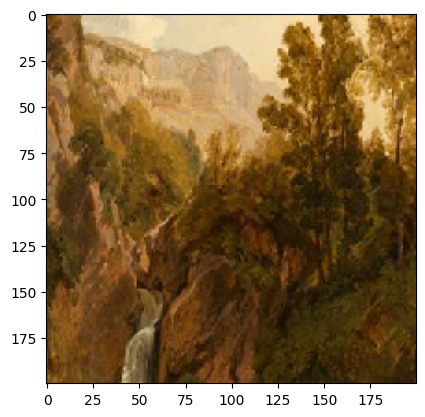

In [24]:
#################################################
#Validate on an image
#img = image.load_img('movie_dataset_multilabel/images/tt4425064.jpg', target_size=(SIZE,SIZE,3))
image_idx = 29999
img = image.image_utils.load_img(str(image_idx)+'.jpg', target_size=(SIZE,SIZE,3))

img = image.image_utils.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)

classes = np.array(df.columns[5:]) #Get array of all classes
proba = model.predict(img)  #Get probabilities for each class
sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories

#Print classes and corresponding probabilities
for i in range(len(styles)):
    print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))

###################################################

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

################################################################

"""
"""





In [25]:
print(df.loc[image_idx,:])

Style                                                Romanticism
Artwork                                                  Subiaco
Artist                                            Penry Williams
Date                                                        1834
Link           https://uploads5.wikiart.org/00360/images/penr...
Barroque                                                       0
Neoclassism                                                    0
Romanticism                                                    1
Realism                                                        0
Name: 29999, dtype: object
